In [ ]:

#To read directly from Drive in Google Colab use:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Path to our folder in Drive
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


### Import dependencies

In [ ]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seaborn as sns
import matplotlib.pyplot as plt
!pip install tf-explain
from tf_explain.core.grad_cam import GradCAM

!pip install optuna
import optuna
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Input, Flatten
from keras.layers.experimental.preprocessing import Rescaling, RandomFlip, Normalization
from keras.utils import plot_model
from tensorflow.keras.regularizers import l1, l2

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D

from keras.models import Model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.8 MB/s eta 0:00:00


In [ ]:
def load_data(dataset_dir, img_size, batch_size, preprocessing_method):
    # Load and preprocess the training dataset
    train_dataset = keras.preprocessing.image_dataset_from_directory(
      directory=dataset_dir+'/train/',
      labels='inferred',
      label_mode='categorical',
      batch_size=batch_size,
      class_names=['coast', 'forest', 'highway', 'inside_city', 'mountain', 'Opencountry', 'street', 'tallbuilding'],
      image_size=(img_size, img_size),
      shuffle=True,
      validation_split=None,
      subset=None
    )

    # Load and preprocess the validation dataset
    validation_dataset = keras.preprocessing.image_dataset_from_directory(
      directory=dataset_dir+'/test/',
      labels='inferred',
      label_mode='categorical',
      batch_size=batch_size,
      class_names=['coast', 'forest', 'highway', 'inside_city', 'mountain', 'Opencountry', 'street', 'tallbuilding'],
      image_size=(img_size, img_size),
      shuffle=True,
      seed=123,
      validation_split=None,
      subset=None
    )

    # train_dataset = train_dataset.take(int(len(train_dataset) * 0.1))
    # validation_dataset = validation_dataset.take(int(len(validation_dataset) * 0.1))

    # Data augmentation and preprocessing
    preprocessing_train = keras.Sequential([
      RandomFlip("horizontal")
    ])

    preprocessing_validation = keras.Sequential()

    if preprocessing_method == 'rescaling':
        preprocessing_train.add(Rescaling(1./255))
        preprocessing_validation.add(Rescaling(1./255))
    elif preprocessing_method == 'normalization':
        preprocessing_train.add(Normalization()) #standardization z-score
        preprocessing_validation.add(Normalization())

    train_dataset = train_dataset.map(lambda x, y: (preprocessing_train(x, training=True), y))
    validation_dataset = validation_dataset.map(lambda x, y: (preprocessing_validation(x, training=False), y))

    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, validation_dataset

TO RUN

In [ ]:
DATASET_DIR = './MIT_split'

IMG_HEIGHT=299
IMG_WIDTH = 299
BATCH_SIZE=16
NUMBER_OF_EPOCHS=20

train_dataset, validation_dataset = load_data(DATASET_DIR, IMG_HEIGHT, BATCH_SIZE, preprocessing_method = 'rescaling')

Found 1881 files belonging to 8 classes.
Found 807 files belonging to 8 classes.


87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/20
118/118 - 320s - loss: 0.9437 - accuracy: 0.7645 - val_loss: 0.4922 - val_accuracy: 0.9058 - 320s/epoch - 3s/step
Epoch 2/20
118/118 - 15s - loss: 0.4065 - accuracy: 0.9001 - val_loss: 0.3519 - val_accuracy: 0.9120 - 15s/epoch - 127ms/step
Epoch 3/20
118/118 - 17s - loss: 0.3128 - accuracy: 0.9208 - val_loss: 0.2997 - val_accuracy: 0.9232 - 17s/epoch - 145ms/step
Epoch 4/20
118/118 - 17s - loss: 0.2723 - accuracy: 0.9203 - val_loss: 0.2775 - val_accuracy: 0.9195 - 17s/epoch - 143ms/step
Epoch 5/20
118/118 - 17s - loss: 0.2443 - accuracy: 0.9320 - val_loss: 0.2542 - val_accuracy: 0.9281 - 17s/epoch - 148ms/step
Epoch 6/20
118/118 - 20s - loss: 0.2203 - accuracy: 0.9378 - val_loss: 0.2421 - val_accuracy: 0.9281 - 20s/epoch - 168ms/step
Epoch 7/20
118/118 - 16s - loss: 0.2056 - accuracy: 0.9436 - val_loss: 0.2318 - val_accuracy: 0.9294 - 16s/epoch - 138ms/step
Epoch 8/20
118/118 - 16s - loss: 0.1960 - accuracy: 0.

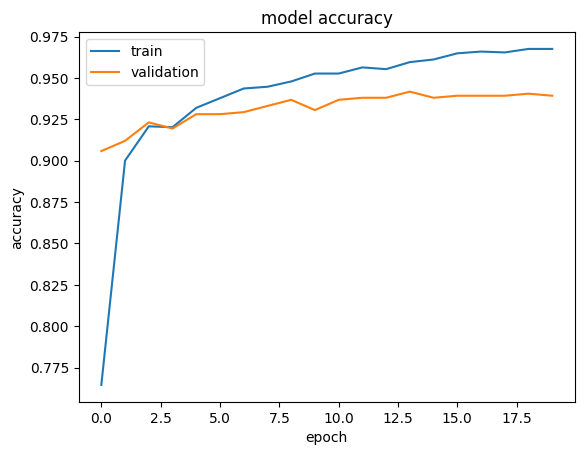

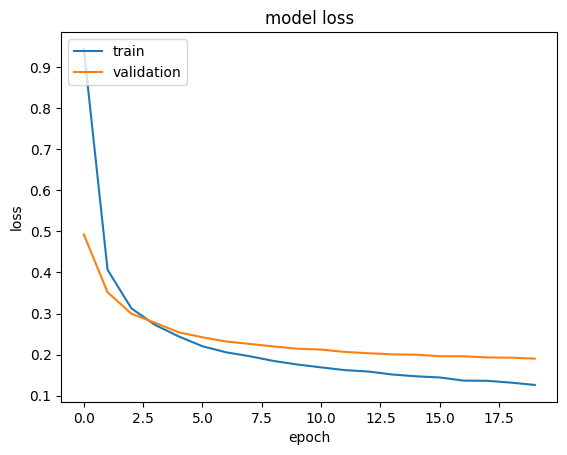

0.9392812848091125


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

#freeze all the previous layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(8, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('accuracy_task1_s1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_task1_s1.jpg')
plt.show()
print(history.history['val_accuracy'][-1])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

Epoch 1/20
118/118 - 20s - loss: 1.7056 - accuracy: 0.5008 - val_loss: 1.3359 - val_accuracy: 0.8116 - 20s/epoch - 171ms/step
Epoch 2/20
118/118 - 16s - loss: 1.1350 - accuracy: 0.8591 - val_loss: 0.9497 - val_accuracy: 0.9108 - 16s/epoch - 132ms/step
Epoch 3/20
118/118 - 15s - loss: 0.8432 - accuracy: 0.9075 - val_loss: 0.7351 - val_accuracy: 0.9269 - 15s/epoch - 124ms/step
Epoch 4/20
118/118 - 15s - loss: 0.6762 - accuracy: 0.9256 - val_loss: 0.6093 - val_accuracy: 0.9405 - 15s/epoch - 129ms/step
Epoch 5/20
118/118 - 16s - loss: 0.5736 - accuracy: 0.9282 - val_loss: 0.5284 - val_accuracy: 0.9480 - 16s/epoch - 140ms/step
Epoch 6/20
118/118 - 15s - loss: 0.5021 - accuracy: 0.9335 - val_loss: 0.4677 - val_accuracy: 0.9480 - 15s/epoch - 125ms/step
Epoch 7/20
118/118 - 15s - loss: 0.4523 - accuracy: 0.9410 - val_loss: 0.4249 - val_accuracy: 0.9480 - 15s/epoch - 128ms/step
Epoch 8/20
118/118 - 15s - loss: 0.4119 - accuracy: 0.9389 - val_loss: 0.3921 - val_accuracy: 0.9504 - 15s/epoch - 126

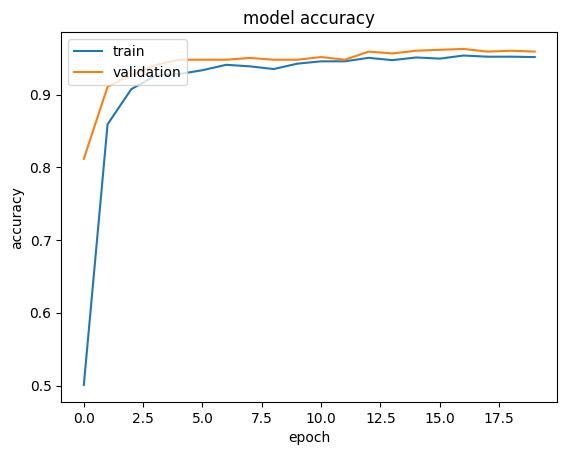

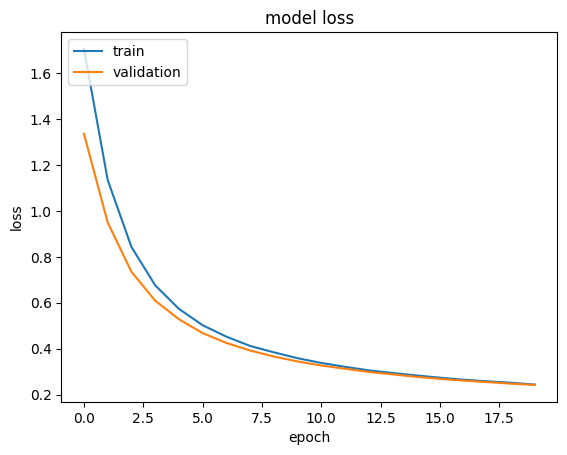

0.9591078162193298


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

#freeze all the previous layers
base_model.trainable = False

input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.layers[248].output
x = GlobalAveragePooling2D()(x)
outputs = Dense(8, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('accuracy_task1_s1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_task1_s1.jpg')
plt.show()
print(history.history['val_accuracy'][-1])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

Epoch 1/20
118/118 - 20s - loss: 1.6133 - accuracy: 0.4301 - val_loss: 1.3182 - val_accuracy: 0.5551 - 20s/epoch - 172ms/step
Epoch 2/20
118/118 - 17s - loss: 1.1708 - accuracy: 0.6326 - val_loss: 1.0798 - val_accuracy: 0.6382 - 17s/epoch - 144ms/step
Epoch 3/20
118/118 - 15s - loss: 1.0081 - accuracy: 0.6752 - val_loss: 1.0026 - val_accuracy: 0.6791 - 15s/epoch - 130ms/step
Epoch 4/20
118/118 - 16s - loss: 0.9314 - accuracy: 0.6917 - val_loss: 0.9330 - val_accuracy: 0.6642 - 16s/epoch - 132ms/step
Epoch 5/20
118/118 - 17s - loss: 0.8685 - accuracy: 0.7044 - val_loss: 0.9139 - val_accuracy: 0.6729 - 17s/epoch - 142ms/step
Epoch 6/20
118/118 - 18s - loss: 0.8206 - accuracy: 0.7135 - val_loss: 0.8319 - val_accuracy: 0.7113 - 18s/epoch - 154ms/step
Epoch 7/20
118/118 - 15s - loss: 0.7847 - accuracy: 0.7395 - val_loss: 0.8086 - val_accuracy: 0.7249 - 15s/epoch - 127ms/step
Epoch 8/20
118/118 - 15s - loss: 0.7556 - accuracy: 0.7544 - val_loss: 0.8079 - val_accuracy: 0.7051 - 15s/epoch - 126

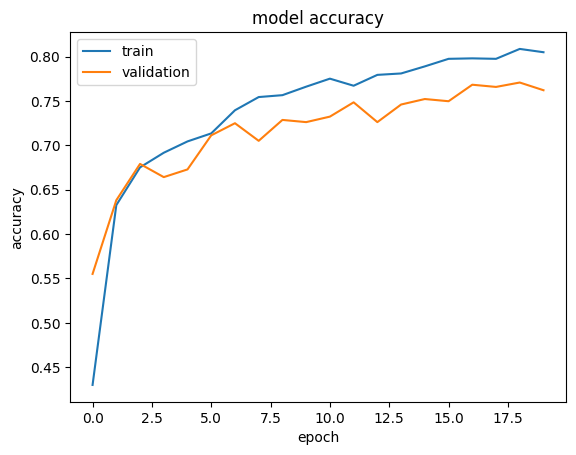

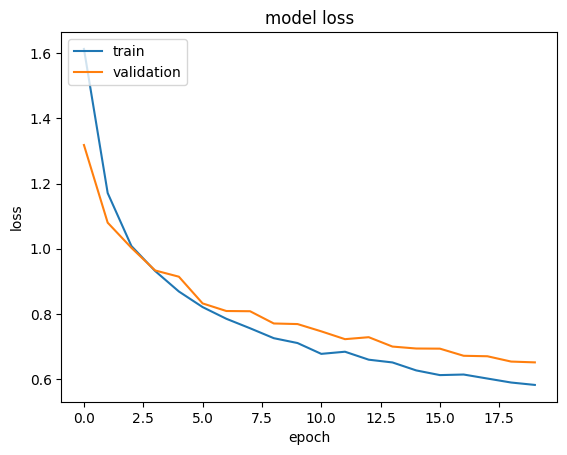

0.7620818018913269


In [ ]:
base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

base_model.trainable = False

model_part1 = Model(inputs=base_model.input, outputs=base_model.layers[63].output)
model_part2 = Model(inputs=base_model.layers[86].output, outputs=base_model.layers[-1].output)


combined_model = Model(inputs=model_part1.input, outputs=model_part2(model_part1.output))

x = GlobalAveragePooling2D()(combined_model.output)
outputs = Dense(8, activation="softmax")(x)

model = Model(inputs=model_part1.input, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('accuracy_task1_s1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_task1_s1.jpg')
plt.show()
print(history.history['val_accuracy'][-1])

Epoch 1/20
118/118 - 20s - loss: 1.6408 - accuracy: 0.4226 - val_loss: 1.3367 - val_accuracy: 0.5750 - 20s/epoch - 171ms/step
Epoch 2/20
118/118 - 16s - loss: 1.1720 - accuracy: 0.6645 - val_loss: 1.0705 - val_accuracy: 0.7076 - 16s/epoch - 137ms/step
Epoch 3/20
118/118 - 16s - loss: 0.9968 - accuracy: 0.7204 - val_loss: 0.9579 - val_accuracy: 0.7299 - 16s/epoch - 132ms/step
Epoch 4/20
118/118 - 14s - loss: 0.8945 - accuracy: 0.7443 - val_loss: 0.8700 - val_accuracy: 0.7584 - 14s/epoch - 121ms/step
Epoch 5/20
118/118 - 16s - loss: 0.8200 - accuracy: 0.7613 - val_loss: 0.8237 - val_accuracy: 0.7608 - 16s/epoch - 139ms/step
Epoch 6/20
118/118 - 19s - loss: 0.7613 - accuracy: 0.7804 - val_loss: 0.7763 - val_accuracy: 0.7621 - 19s/epoch - 161ms/step
Epoch 7/20
118/118 - 15s - loss: 0.7232 - accuracy: 0.7943 - val_loss: 0.7590 - val_accuracy: 0.7807 - 15s/epoch - 124ms/step
Epoch 8/20
118/118 - 14s - loss: 0.6904 - accuracy: 0.8012 - val_loss: 0.7205 - val_accuracy: 0.7918 - 14s/epoch - 121

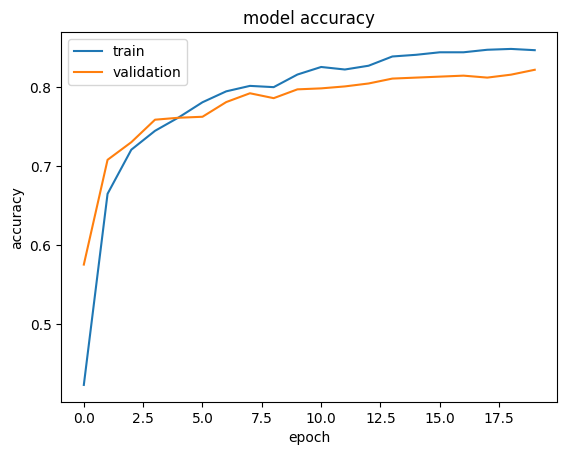

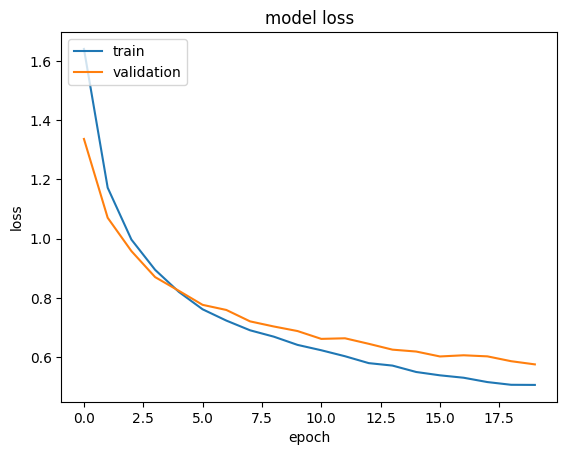

0.821561336517334


In [ ]:
base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

base_model.trainable = False

model_part1 = Model(inputs=base_model.input, outputs=base_model.layers[132].output)
model_part2 = Model(inputs=base_model.layers[164].output, outputs=base_model.layers[-1].output)


combined_model = Model(inputs=model_part1.input, outputs=model_part2(model_part1.output))

x = GlobalAveragePooling2D()(combined_model.output)
outputs = Dense(8, activation="softmax")(x)

model = Model(inputs=model_part1.input, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('accuracy_task1_s1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_task1_s1.jpg')
plt.show()
print(history.history['val_accuracy'][-1])

Epoch 1/20
118/118 - 20s - loss: 2.0363 - accuracy: 0.1483 - val_loss: 1.9865 - val_accuracy: 0.2243 - 20s/epoch - 167ms/step
Epoch 2/20
118/118 - 14s - loss: 1.9474 - accuracy: 0.3068 - val_loss: 1.9048 - val_accuracy: 0.3172 - 14s/epoch - 119ms/step
Epoch 3/20
118/118 - 17s - loss: 1.8679 - accuracy: 0.4551 - val_loss: 1.8282 - val_accuracy: 0.4597 - 17s/epoch - 142ms/step
Epoch 4/20
118/118 - 16s - loss: 1.7930 - accuracy: 0.5641 - val_loss: 1.7559 - val_accuracy: 0.6518 - 16s/epoch - 138ms/step
Epoch 5/20
118/118 - 17s - loss: 1.7247 - accuracy: 0.6629 - val_loss: 1.6895 - val_accuracy: 0.6828 - 17s/epoch - 143ms/step
Epoch 6/20
118/118 - 19s - loss: 1.6594 - accuracy: 0.7220 - val_loss: 1.6270 - val_accuracy: 0.7410 - 19s/epoch - 160ms/step
Epoch 7/20
118/118 - 15s - loss: 1.5990 - accuracy: 0.7618 - val_loss: 1.5683 - val_accuracy: 0.7695 - 15s/epoch - 126ms/step
Epoch 8/20
118/118 - 15s - loss: 1.5425 - accuracy: 0.7900 - val_loss: 1.5140 - val_accuracy: 0.7955 - 15s/epoch - 129

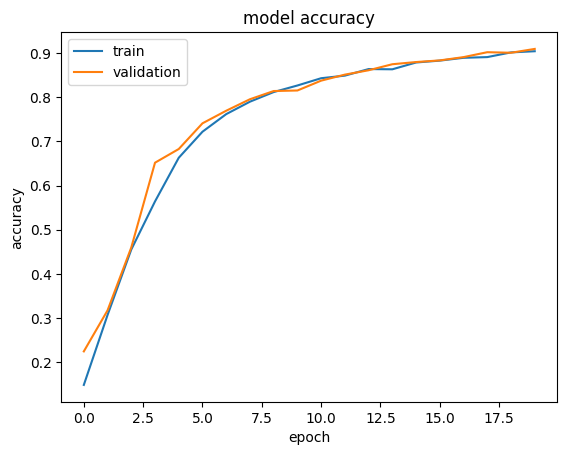

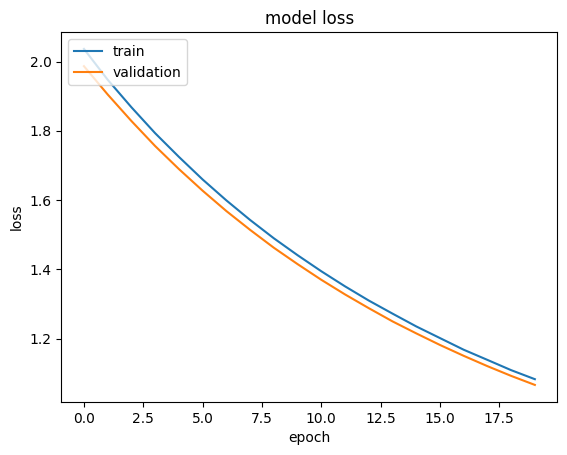

0.9095414876937866


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

#freeze all the previous layers
base_model.trainable = False

input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.layers[228].output
x = GlobalAveragePooling2D()(x)
outputs = Dense(8, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('accuracy_task1_s1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_task1_s1.jpg')
plt.show()
print(history.history['val_accuracy'][-1])

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 149, 149, 32)         864       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 149, 149, 32)         96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_3

Epoch 1/20
118/118 - 18s - loss: 1.8911 - accuracy: 0.3982 - val_loss: 1.6902 - val_accuracy: 0.6146 - 18s/epoch - 152ms/step
Epoch 2/20
118/118 - 15s - loss: 1.5495 - accuracy: 0.7315 - val_loss: 1.4137 - val_accuracy: 0.7943 - 15s/epoch - 123ms/step
Epoch 3/20
118/118 - 14s - loss: 1.3129 - accuracy: 0.8426 - val_loss: 1.2140 - val_accuracy: 0.8525 - 14s/epoch - 119ms/step
Epoch 4/20
118/118 - 14s - loss: 1.1390 - accuracy: 0.8830 - val_loss: 1.0624 - val_accuracy: 0.8910 - 14s/epoch - 122ms/step
Epoch 5/20
118/118 - 15s - loss: 1.0096 - accuracy: 0.9064 - val_loss: 0.9487 - val_accuracy: 0.9133 - 15s/epoch - 124ms/step
Epoch 6/20
118/118 - 16s - loss: 0.9092 - accuracy: 0.9133 - val_loss: 0.8607 - val_accuracy: 0.9257 - 16s/epoch - 137ms/step
Epoch 7/20
118/118 - 14s - loss: 0.8283 - accuracy: 0.9272 - val_loss: 0.7896 - val_accuracy: 0.9244 - 14s/epoch - 121ms/step
Epoch 8/20
118/118 - 14s - loss: 0.7637 - accuracy: 0.9250 - val_loss: 0.7304 - val_accuracy: 0.9281 - 14s/epoch - 121

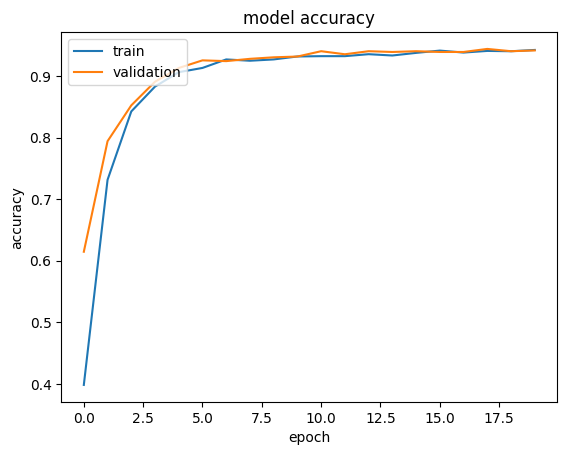

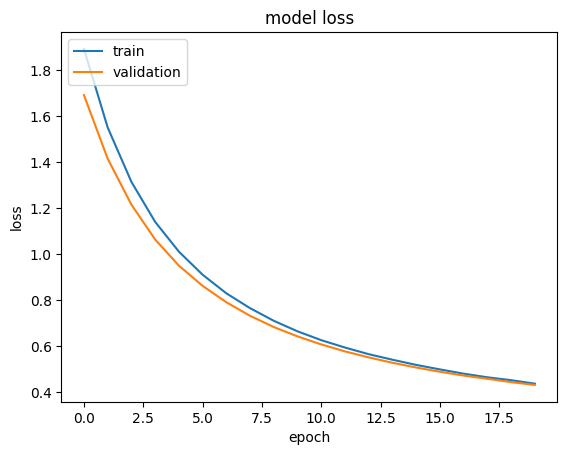

0.9417595863342285


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

#freeze all the previous layers
base_model.trainable = False

input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.layers[196].output
x = GlobalAveragePooling2D()(x)
outputs = Dense(8, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('accuracy_task1_s1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_task1_s1.jpg')
plt.show()
print(history.history['val_accuracy'][-1])

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_470 (Conv2D)         (None, 149, 149, 32)         864       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_470 (B  (None, 149, 149, 32)         96        ['conv2d_470[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_4

87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/20
118/118 - 610s - loss: 1.8971 - accuracy: 0.3636 - val_loss: 1.6546 - val_accuracy: 0.4820 - 610s/epoch - 5s/step
Epoch 2/20
118/118 - 13s - loss: 1.5061 - accuracy: 0.6465 - val_loss: 1.3523 - val_accuracy: 0.7150 - 13s/epoch - 114ms/step
Epoch 3/20
118/118 - 16s - loss: 1.2608 - accuracy: 0.7820 - val_loss: 1.1602 - val_accuracy: 0.7497 - 16s/epoch - 135ms/step
Epoch 4/20
118/118 - 14s - loss: 1.0948 - accuracy: 0.8347 - val_loss: 1.0176 - val_accuracy: 0.8401 - 14s/epoch - 117ms/step
Epoch 5/20
118/118 - 15s - loss: 0.9739 - accuracy: 0.8628 - val_loss: 0.9167 - val_accuracy: 0.8550 - 15s/epoch - 123ms/step
Epoch 6/20
118/118 - 16s - loss: 0.8824 - accuracy: 0.8942 - val_loss: 0.8366 - val_accuracy: 0.8748 - 16s/epoch - 137ms/step
Epoch 7/20
118/118 - 16s - loss: 0.8111 - accuracy: 0.8990 - val_loss: 0.7765 - val_accuracy: 0.8786 - 16s/epoch - 137ms/step
Epoch 8/20
118/118 - 14s - loss: 0.7541 - accuracy: 0.

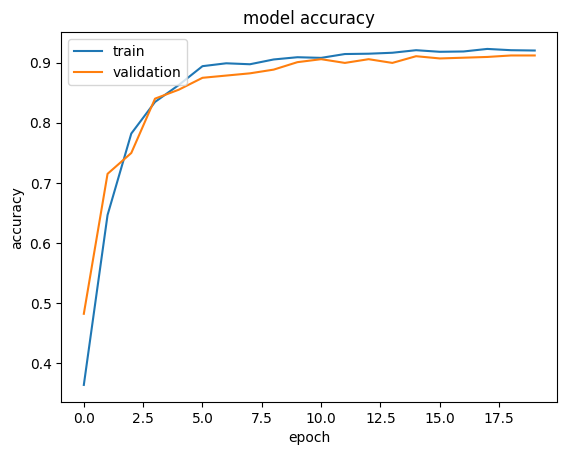

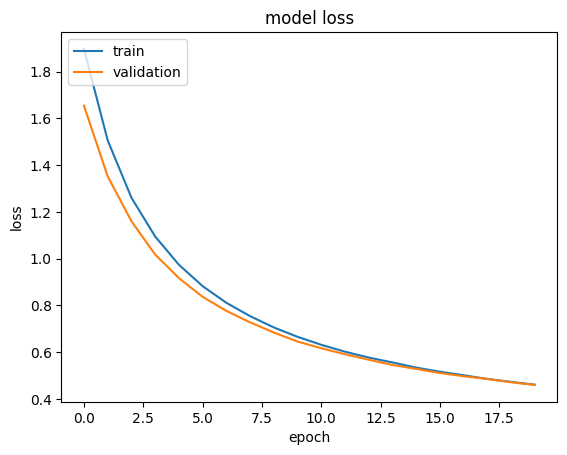

0.9120198488235474


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

#freeze all the previous layers
base_model.trainable = False

input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.layers[132].output
x = GlobalAveragePooling2D()(x)
outputs = Dense(8, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('accuracy_task1_s1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('loss_task1_s1.jpg')
plt.show()
print(history.history['val_accuracy'][-1])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
def best_model():
    base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

    base_model.trainable = False

    input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model.layers[248].output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(8, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

    return model


IMG_HEIGHT=299
IMG_WIDTH = 299
BATCH_SIZE=16
NUMBER_OF_EPOCHS=20

results = []

for i in range(1,5):
    DATASET_DIR = './MIT_small_train_'+str(i)
    train_dataset, validation_dataset = load_data(DATASET_DIR, IMG_HEIGHT, BATCH_SIZE, preprocessing_method = 'rescaling')

    model = best_model()
    history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)
    results.append(history)


# # train the model on the new data for a few epochs
# history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# #plt.savefig('accuracy_task1_s1.jpg')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# #plt.savefig('loss_task1_s1.jpg')
# plt.show()
# print(history.history['val_accuracy'][-1])

Found 400 files belonging to 8 classes.
Found 2288 files belonging to 8 classes.
Epoch 1/20
25/25 - 459s - loss: 1.9925 - accuracy: 0.2375 - val_loss: 1.8626 - val_accuracy: 0.3711 - 459s/epoch - 18s/step
Epoch 2/20
25/25 - 13s - loss: 1.7917 - accuracy: 0.5275 - val_loss: 1.6857 - val_accuracy: 0.6630 - 13s/epoch - 519ms/step
Epoch 3/20
25/25 - 13s - loss: 1.6190 - accuracy: 0.7225 - val_loss: 1.5341 - val_accuracy: 0.7705 - 13s/epoch - 530ms/step
Epoch 4/20
25/25 - 23s - loss: 1.4678 - accuracy: 0.7825 - val_loss: 1.4061 - val_accuracy: 0.8566 - 23s/epoch - 913ms/step
Epoch 5/20
25/25 - 12s - loss: 1.3378 - accuracy: 0.8700 - val_loss: 1.2973 - val_accuracy: 0.8413 - 12s/epoch - 500ms/step
Epoch 6/20
25/25 - 13s - loss: 1.2317 - accuracy: 0.8700 - val_loss: 1.1942 - val_accuracy: 0.8907 - 13s/epoch - 523ms/step
Epoch 7/20
25/25 - 13s - loss: 1.1330 - accuracy: 0.8850 - val_loss: 1.1150 - val_accuracy: 0.9043 - 13s/epoch - 538ms/step
Epoch 8/20
25/25 - 23s - loss: 1.0536 - accuracy: 0

In [ ]:
def best_model():
    base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

    base_model.trainable = False

    input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model.layers[196].output

    x = keras.layers.Conv2D(32, (8, 8),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Dense(24)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = Dense(8, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

    return model


DATASET_DIR = './MIT_small_train_1'

IMG_HEIGHT=299
IMG_WIDTH = 299
BATCH_SIZE=16
NUMBER_OF_EPOCHS=20

trans_values = [10, 0.1, 0.1, 0.1, [0.8, 1.2], 0.1, True]

for i, v in enumerate(trans_values):
    v_range = 0
    w_shift = 0.
    h_shift = 0.
    shear = 0.
    brightnes = [1., 1.]
    zoom = 0.
    h_flip = False

    if i == 0:
        v_range = v
    if i == 1:
        w_shift = v
    if i == 2:
        h_shift = v
    if i == 3:
        shear = v
    if i == 4:
        brightnes = v
    if i == 5:
        zoom = v
    if i == 6:
        h_flip = v

    train_data_generator = ImageDataGenerator(featurewise_center=False,
                                              samplewise_center=False,
                                              featurewise_std_normalization=False,
                                              samplewise_std_normalization=False,
                                              preprocessing_function=preprocess_input,
                                              rotation_range=v_range,
                                              width_shift_range=w_shift,
                                              height_shift_range=h_shift,
                                              shear_range=shear,
                                              brightness_range=brightnes,
                                              zoom_range=zoom,
                                              fill_mode='nearest',
                                              horizontal_flip=h_flip,
                                              vertical_flip=False,
                                              rescale=None)

    validation_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_dataset = train_data_generator.flow_from_directory(
        directory=DATASET_DIR+'/train/',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True)

    validation_dataset = validation_data_generator.flow_from_directory(
        directory=DATASET_DIR+'/test/',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True)

    model = best_model()
    history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig('accuracy_task1_s1.jpg')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig('loss_task1_s1.jpg')
    plt.show()
    print(history.history['val_accuracy'][-1])

In [ ]:
def best_model():
    base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

    base_model.trainable = False

    input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model.layers[196].output

    x = keras.layers.Conv2D(32, (8, 8),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Dense(24)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = Dense(8, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

    return model


DATASET_DIR = './MIT_small_train_1'

IMG_HEIGHT=299
IMG_WIDTH = 299
BATCH_SIZE=16
NUMBER_OF_EPOCHS=20

for i in range(6):
    r_range = 0
    w_shift = 0.
    h_shift = 0.
    shear = 0.
    brightnes = [1., 1.]
    zoom = 0.
    h_flip = False

    if i == 0:
        brightnes = [0.7, 1.3]
        h_flip = True
    if i == 1:
        brightnes = [0.7, 1.3]
        h_flip = True
        w_shift = 0.2
    if i == 2:
        brightnes = [0.7, 1.3]
        h_flip = True
        r_range = 0.2
    if i == 3:
        brightnes = [0.7, 1.3]
        h_flip = True
        w_shift = 0.2
        r_range = 0.2
    if i == 4:
        brightnes = [0.7, 1.3]
        h_flip = True
        w_shift = 0.2
        shear = 0.2
    if i == 5:
        r_range = 20
        w_shift = 0.2
        h_shift = 0.2
        shear = 0.2
        brightnes = [0.7, 1.3]
        h_flip = True

    train_data_generator = ImageDataGenerator(featurewise_center=False,
                                              samplewise_center=False,
                                              featurewise_std_normalization=False,
                                              samplewise_std_normalization=False,
                                              preprocessing_function=preprocess_input,
                                              rotation_range=r_range,
                                              width_shift_range=w_shift,
                                              height_shift_range=h_shift,
                                              shear_range=shear,
                                              brightness_range=brightnes,
                                              zoom_range=zoom,
                                              fill_mode='nearest',
                                              horizontal_flip=h_flip,
                                              vertical_flip=False,
                                              rescale=None)

    validation_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_dataset = train_data_generator.flow_from_directory(
        directory=DATASET_DIR+'/train/',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True)

    validation_dataset = validation_data_generator.flow_from_directory(
        directory=DATASET_DIR+'/test/',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True)

    model = best_model()
    history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig('accuracy_task1_s1.jpg')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig('loss_task1_s1.jpg')
    plt.show()
    print(i, history.history['val_accuracy'][-1])

In [ ]:
img_size = 299
dataset_dir = './MIT_split'
batch_size = 16
class_names=['coast', 'forest', 'highway', 'inside_city', 'mountain', 'Opencountry', 'street', 'tallbuilding']

dataset = np.random.choice(os.listdir(dataset_dir), 1)[0]
cls =  np.random.choice(class_names, 1)[0]
img = np.random.choice(os.listdir(os.path.join(os.path.join(dataset_dir, dataset), cls)), 1)[0]
img_path = os.path.join(os.path.join(os.path.join(dataset_dir, dataset), cls), img)
img_load = image.load_img(img_path, target_size=(img_size, img_size))
img_tensor = image.img_to_array(img_load)
img_tensor = np.expand_dims(img_tensor, axis=0)

plt.imshow(img_load)
plt.axis('off')
plt.show()



datagen = ImageDataGenerator(rotation_range=10, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(width_shift_range=0.1, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(width_shift_range=0.2, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(height_shift_range=0.1, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(height_shift_range=0.2, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(shear_range=0.5, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(shear_range=0.8, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(brightness_range=[0.6, 1.4], fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(brightness_range=[0.8, 1.2], fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(zoom_range=0.8)
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(zoom_range=0.5, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(horizontal_flip=True, fill_mode='nearest')
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.3,
                                          height_shift_range=0.3,
                                          shear_range=0.3,
                                          brightness_range=[0.7, 1.3],
                                          zoom_range=0.3,
                                          fill_mode='nearest',
                                          horizontal_flip=True,
                                          vertical_flip=False,
                                          rescale=None)
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.3,
                                          height_shift_range=0.3,
                                          shear_range=0.3,
                                          brightness_range=[0.7, 1.3],
                                          zoom_range=0.3,
                                          fill_mode='nearest',
                                          horizontal_flip=True,
                                          vertical_flip=False,
                                          rescale=None)
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()
datagen = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.3,
                                          height_shift_range=0.3,
                                          shear_range=0.3,
                                          brightness_range=[0.7, 1.3],
                                          zoom_range=0.3,
                                          fill_mode='nearest',
                                          horizontal_flip=True,
                                          vertical_flip=False,
                                          rescale=None)
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()
datagen = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.3,
                                          height_shift_range=0.3,
                                          shear_range=0.3,
                                          brightness_range=[0.7, 1.3],
                                          zoom_range=0.3,
                                          fill_mode='nearest',
                                          horizontal_flip=True,
                                          vertical_flip=False,
                                          rescale=None)
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.3,
                                          height_shift_range=0.3,
                                          shear_range=0.3,
                                          brightness_range=[0.7, 1.3],
                                          zoom_range=0.3,
                                          fill_mode='nearest',
                                          horizontal_flip=True,
                                          vertical_flip=False,
                                          rescale=None)
pic = datagen.flow(img_tensor, batch_size =1).next()[0].astype('uint8')
plt.imshow(pic)
plt.axis('off')
plt.show()

In [ ]:
def best_model():
    base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

    base_model.trainable = False

    x = base_model.layers[196].output

    x = keras.layers.Conv2D(32, (8, 8),padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Dense(24)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = Dense(8, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

    for layer in model.layers[165:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

    return model

IMG_HEIGHT=299
IMG_WIDTH = 299
BATCH_SIZE=16
NUMBER_OF_EPOCHS=20

results = []

for i in range(1,5):
    DATASET_DIR = './MIT_small_train_'+str(i)
    train_dataset, validation_dataset = load_data_augmented(DATASET_DIR, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, preprocess_input)

    model = best_model()
    history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)
    results.append(history)

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig('accuracy_task1_s1.jpg')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig('loss_task1_s1.jpg')
    plt.show()
    print(history.history['val_accuracy'][-1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Iterar sobre los resultados de entrenamiento de cada conjunto de datos
for i in range(4):
    # Precisión
    ax1.plot(results[i].history['accuracy'], label=f'Dataset small {i+1} - Train')
    ax1.plot(results[i].history['val_accuracy'], label=f'Dataset small {i+1} - Validation')

    # Pérdida
    ax2.plot(results[i].history['loss'], label=f'Dataset small {i+1} - Train')
    ax2.plot(results[i].history['val_loss'], label=f'Dataset small {i+1} - Validation')

# Configurar leyendas y etiquetas
ax1.legend()
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.legend()
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from tf_explain.core.grad_cam import GradCAM


img_size = 299
dataset_dir = './MIT_split'
class_names=['coast', 'forest', 'highway', 'inside_city', 'mountain', 'Opencountry', 'street', 'tallbuilding']

base_model = InceptionV3(weights='imagenet', input_shape=(img_size, img_size, 3), include_top=True)

layers = [1, 40, 100, 164, 248, 310]
n_images = 3
samples_level = 4

fig, axes = plt.subplots(n_images, len(layers)+1, figsize=(16, int(n_images*2.5)))
fig2, axes2 = plt.subplots(samples_level, len(layers), figsize=(14, int(samples_level*2.0)))
fig3, axes3 = plt.subplots(n_images, len(layers)+1, figsize=(16, int(n_images*2.5)))


for i in range(n_images):
    dataset = np.random.choice(os.listdir(dataset_dir), 1)[0]
    cls =  np.random.choice(class_names, 1)[0]
    img = np.random.choice(os.listdir(os.path.join(os.path.join(dataset_dir, dataset), cls)), 1)[0]
    img_path = os.path.join(os.path.join(os.path.join(dataset_dir, dataset), cls), img)
    img_load = image.load_img(img_path, target_size=(img_size, img_size))

    x = image.img_to_array(img_load)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    for col, layer in enumerate(layers):
        model = Model(inputs=base_model.input, outputs=base_model.layers[layer].output)
        explainer = GradCAM()
        grid = explainer.explain((x, None), base_model, class_index=np.where(np.array(class_names) == cls)[0][0], layer_name=model.layers[layer].name)

        features = model.predict(x, verbose = 0)
        axes[i][col+1].imshow(features[0,:,:,0], cmap='viridis', aspect='auto')
        axes[i][col+1].axis('off')
        axes3[i][col+1].imshow(grid, aspect='auto')
        axes3[i][col+1].axis('off')

        if i == 0:
            axes[i][col+1].set_title(f'{base_model.layers[layer].name} layer {layer}')
            axes3[i][col+1].set_title(f'{base_model.layers[layer].name} layer {layer}')

        if i == 0:
            feature_index = np.random.choice(range(features.shape[3]), 4, replace = False)
            for j, feat_idx in enumerate(feature_index):
                axes2[j][col].imshow(features[0,:,:,feat_idx], cmap='viridis', aspect='auto')
                axes2[j][col].axis('off')
                if j == 0:
                    axes2[j][col].set_title(f'{base_model.layers[layer].name} layer {layer}')
    axes[i][0].imshow(img_load, aspect='auto')
    axes[i][0].axis('off')
    axes3[i][0].imshow(img_load, aspect='auto')
    axes3[i][0].axis('off')
    if i == 0:
        axes[i][0].set_title(f'Original')
        axes3[i][0].set_title(f'Original')

plt.show()


fig.savefig('feature_maps_images.jpg')
fig2.savefig('feature_maps_multi.jpg')
fig3.savefig('feature_maps_grad_cam.jpg')

In [ ]:
##### HOW TO REMOVE MULTIPLE INNER BLOCKS #####

# base_model = InceptionV3(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# base_model.trainable = False

# model_part1 = Model(inputs=base_model.input, outputs=base_model.layers[63].output)
# model_part2 = Model(inputs=base_model.layers[86].output, outputs=base_model.layers[100].output)

# model_part3 = Model(inputs=base_model.layers[100].output, outputs=base_model.layers[228].output)
# model_part4 = Model(inputs=base_model.layers[228].output, outputs=base_model.layers[279].output)

# combined_model = Model(inputs=model_part1.input, outputs=model_part4(model_part3(model_part2(model_part1.output))))

# x = GlobalAveragePooling2D()(combined_model.output)
# outputs = Dense(8, activation="softmax")(x)

# model = Model(inputs=model_part1.input, outputs=outputs)

# model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# # train the model on the new data for a few epochs
# history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, verbose=2)

# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# #plt.savefig('accuracy_task1_s1.jpg')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# #plt.savefig('loss_task1_s1.jpg')
# plt.show()
# print(history.history['val_accuracy'][-1])